# Setting Up an Image Pipeline

**Objective**

Write and test custom DataSet classes that are going to be used for developing the melanoma classification model. Investigate the data and select a few appropriate transformations from the torchvision.transform package to be used for the data augmentation task. 

Transformations should be set when instantiating a DataSet object; for example, so that one can include different options during training or at test time.



**Workflow**

   1. Upload the dataset from MelanomaDetection.zip to the GPU server. Note that strictly speaking, you do not have to use a GPU for completing this milestone. This step’s objective is to make sure that you know how to get your dataset onto wherever your GPU is, and access it from there.

   2. Write a custom class for the unlabeled images that inherits torch.utils.data.Dataset and overrides the following methods:
        
        1. __init__(self, dir_path, transform=None): the constructor should take in a path to the directory containing images and an optional transform argument for image pre-processing and augmentation.
        2. __len__(self): should return the number of images in the dataset.
        3. __getitem__(self, i): should return the ith image in the set.

   3. Write a custom class for the labeled images that inheritstorch.utils.data.Dataset and overrides the following methods:
        1. __init__(self, dir_path, transform=None): the constructor should take in a path to the directory containing images and an optional transform argument for image pre-processing and augmentation
        2. __len__(self): should return the number of images in the dataset
        3. __getitem__(self, i): should return the ith image in the set as well as its label

   4. Instantiate both classes and create two torch.utils.data.DataLoader objects (for the unlabeled and labeled datasets respectively). Use them to print out one batch of data each.

   5. After looking at the images, what transformations do you propose to use for the pre-processing and the data augmentation?



**Importance to project**

Images are the central part of our melanoma detection project. Naturally, preparing a data pipeline that can handle the pre-processing as well as augmentation of the photos in our dataset is the first piece of code that we write.



In [134]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import timeit    # to evaluate elements of code
import cv2
import tensorflow as tf
import tensorflow.compat.v1 as tf    # to avoid attributeError: 
import random
import tensorflow_addons as tfa
import math
#tf.disable_v2_behavior()             # module 'tensorflow' has no attribute 'placeholder'
#tf.enable_eager_execution() 

## Sample from PyTorch guide

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

### Loading the data

In [3]:


landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]    # iloc - purely integer-location based indexing for selection by position.
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Simple helper function to show an image and its landmarks and use it to show a sample.

In [90]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]    # iloc - purely integer-location based indexing for selection by position.
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


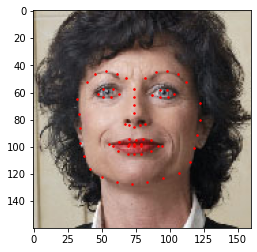

In [91]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

In [92]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Another function to show image on prescribed axes.

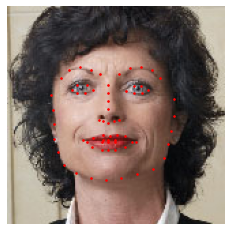

In [93]:
def show_landmarks_ax(ax, image, landmarks):
    """Show image with landmarks"""
    ax.imshow(image)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    ax.axis('off')

fig, ax = plt.subplots();
show_landmarks_ax(ax, io.imread(os.path.join('data/faces/', img_name)),
               landmarks);
plt.show();

Type of extracted data:  <class 'dict'>
0 (324, 215, 3) (68, 2)
Type of extracted data:  <class 'dict'>
1 (500, 333, 3) (68, 2)
Type of extracted data:  <class 'dict'>
2 (250, 258, 3) (68, 2)


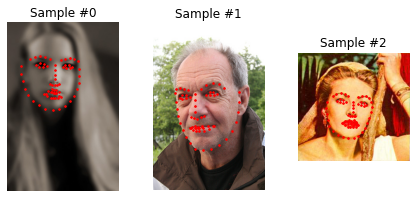

In [94]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3)
axes = [ax_1, ax_2, ax_3]
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print('Type of extracted data: ', type(sample))

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = axes[i]
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks_ax(ax, **sample)

    if i == 2:
        plt.show()
        break



### Transforms

In [95]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

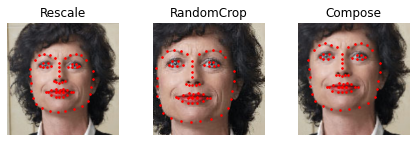

In [96]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3)
axes = [ax_1, ax_2, ax_3]
# Apply each of the above transforms on sample.
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = axes[i]
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks_ax(ax, **transformed_sample)

plt.show()

### Iterating through the dataset

For loop is losing a lot of features by iterating over the data. In particular:

   1. Batching the data,
   2. Shuffling the data,
   3. Load the data in parallel using multiprocessing workers.


In [97]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


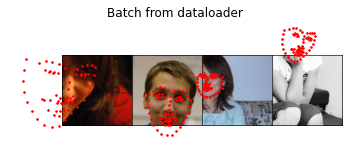

In [106]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


# Milestone itself

# 1. Uploading and downloading the data from GPU

GPU computation time can be very efective.

In [14]:
from numba import vectorize, jit, cuda 
import numpy as np 

from timeit import default_timer as timer            # to measure exec time 

def func(a):                                         # normal function to run on cpu 
    for i in range(10000000): 
        a[i]+= 1    

@vectorize(['float64(float64)'], target ="cuda")     # function optimized to run on gpu                     
def func2(x): 
    return x+1

if __name__=="__main__": 
    n = 10000000                            
    a = np.ones(n, dtype = np.float64) 

    start = timer() 
    func(a) 
    print("without GPU:", timer()-start)     

    start = timer() 
    func2(a) 
    print("with GPU:", timer()-start) 

without GPU: 3.2413397289999466
with GPU: 0.290577968999969


Having the GPU with CUDA locally there is no need to upload it to server.

# 2. Custom class for labeled and unlabeled images

In [2]:
class MelanomaDataset_lab(Dataset):
    """melanoma detection dataset"""

    def __init__(self, images_dir, transform = None):
        """
        Args:
            images_dir (string): directory with all the images.
            transform (callable, optional): optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len([i for i in os.listdir(self.images_dir) if '.jpg' in i])

    def __getitem__(self, idx, through = 'cv'):
        
        try:
            img_name = os.path.join(self.images_dir,
                                    '{}_1.jpg'.format(str(idx)));
            if through == 'skimage':
                image = io.imread(img_name)
            elif through == 'plt':
                image = plt.imread(img_name, format = 'jpg')
            elif through == 'pil':
                image = Image.open(img_name)
            elif through == 'cv':
                image = cv2.imread(img_name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                raise NameError("name '{}' is not defined.".format(thro))
        except:
            img_name = os.path.join(self.images_dir,
                                    '{}_0.jpg'.format(str(idx)));
            if through == 'skimage':
                image = io.imread(img_name)
            elif through == 'plt':
                image = plt.imread(img_name, format = 'jpg')
            elif through == 'pil':
                image = Image.open(img_name)
            elif through == 'cv':
                image = cv2.imread(img_name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                raise NameError("name '{}' is not defined.".format(thro))
        sample = image
        if self.transform != None:
            sample = self.transform(sample)
        return sample

In [3]:
dark_dataset = MelanomaDataset_lab(images_dir = 'MelanomaDetection/MelanomaDetection/labeled')

In [4]:
len(dark_dataset)

200

Type of data extracted:  <class 'numpy.ndarray'>


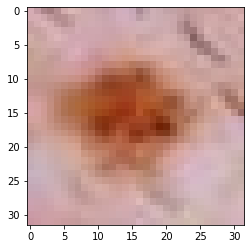

In [5]:
im = dark_dataset[1]
print('Type of data extracted: ', type(im))
plt.imshow(im);

Checking the time of item getting from different packages.

In [6]:
def ev(package):
    return dark_dataset.__getitem__(50, package)

In [7]:
packages = ['skimage', 'plt', 'pil', 'cv']
for i in packages:
    %timeit ev(i);
for i in packages:
    print(type(ev(i)));

214 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
103 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
48.5 µs ± 323 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
45.4 µs ± 874 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>


It is obvious that **CV2 module has the best performance in loading images**. Therefore it will be the default loading option. Analogous class will be applied to unlabeled set.

In [112]:
class MelanomaDataset_unlab(Dataset):
    """melanoma detection dataset"""

    def __init__(self, images_dir, transform = None):
        """
        Args:
            images_dir (string): directory with all the images.
            transform (callable, optional): optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len([i for i in os.listdir(self.images_dir) if '.jpg' in i])

    def __getitem__(self, idx, through = 'cv'):
        
        img_name = os.path.join(self.images_dir,
                                '{}.jpg'.format(str(idx)))
        if through == 'skimage':
            image = io.imread(img_name)
        elif through == 'plt':
            image = plt.imread(img_name, format = 'jpg')
        elif through == 'pil':
            image = Image.open(img_name)
        elif through == 'cv':
            image = cv2.imread(img_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            raise NameError("name '{}' is not defined.".format(thro))
        sample = image
        if self.transform != None:
            sample = self.transform(sample)
        return sample

In [61]:
dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled')

In [62]:
len(dark_dataset_1)

7018

Type of data extracted:  <class 'numpy.ndarray'>


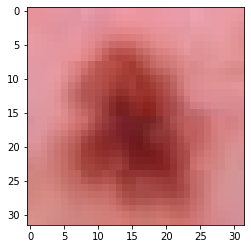

In [63]:
im = dark_dataset_1[1]
print('Type of data extracted: ', type(im))
plt.imshow(im);

Scripts below prints out two batches respectively from labeled and unlabeled data.

Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)


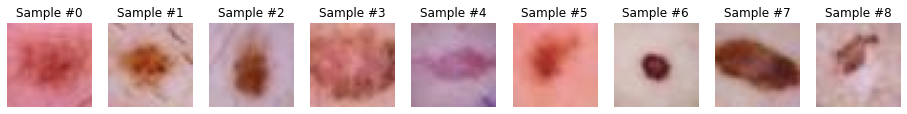

In [64]:
fig, (ax_1, ax_2, ax_3, a_4, a_5, a_6, a_7, a_8, a_9) = plt.subplots(1, 9, figsize=(16,16))
axes = [ax_1, ax_2, ax_3, a_4, a_5, a_6, a_7, a_8, a_9]
for i in range(len(dark_dataset)):
    sample = dark_dataset[i]
    print('Type of extracted data: ', type(sample),  'Shape of image: ', sample.shape)
    ax = axes[i]
    ax.set_title('Sample #{}'.format(i))
    ax.imshow(sample)
    ax.axis('off')

    if i == 8:
        plt.show()
        break

Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)
Type of extracted data:  <class 'numpy.ndarray'> Shape of image:  (32, 32, 3)


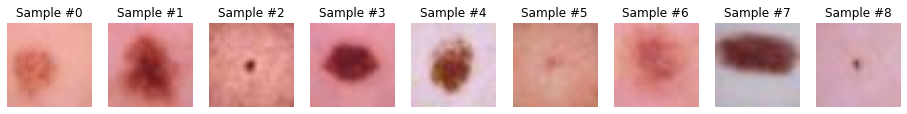

In [65]:
fig, (ax_1, ax_2, ax_3, a_4, a_5, a_6, a_7, a_8, a_9) = plt.subplots(1, 9, figsize=(16,16))
axes = [ax_1, ax_2, ax_3, a_4, a_5, a_6, a_7, a_8, a_9]
for i in range(len(dark_dataset_1)):
    sample = dark_dataset_1[i]
    print('Type of extracted data: ', type(sample), 'Shape of image: ', sample.shape)
    ax = axes[i]
    ax.set_title('Sample #{}'.format(i))
    ax.imshow(sample)
    ax.axis('off')

    if i == 8:
        plt.show()
        break

# 3. Transformations

Main difference between images is **size of marks**. Sizing them back and forth might be a good approach. Another key transformation may be the **rotation**. Although some of marks are symmetrical and some even circular this might give some new, hard to distinguish examples. Another good transformation can be **random crop**. Getting the smaller chunks out of image can give the network some view at non centric marks.

All images in data set have the same shape so there is no need for additional normalisation reshaping, but transformating the extracted images to **tensors** can be very usefull. 

## Rotation and size changing

In [224]:
#https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders/16778797
class Rot_90(object):
    """Rotate the object anticlockwise by 90 degree"""
    def __init__(self, no):
        self.no = no
    def __call__(self, img):
        img = tf.image.rot90(img, self.no)
        return img

class Rot(object):
    """Flip the object with respect to first dimension."""
    def __init__(self, angles):
        self.angles = angles
    def _largest_rotated_rect(self, w, h):
        """
        Given a rectangle of size w x h that has been rotated by 'angle' (in
        radians), computes the width and height of the largest possible
        axis-aligned rectangle within the rotated rectangle.
        Original JS code by 'Andri' and Magnus Hoff from Stack Overflow
        Converted to Python by Aaron Snoswell
        Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
        """
        angle = self.angles
        quadrant = int(math.floor(angle / (math.pi / 2))) & 3
        sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
        alpha = (sign_alpha % math.pi + math.pi) % math.pi

        bb_w = w * math.cos(alpha) + h * math.sin(alpha)
        bb_h = w * math.sin(alpha) + h * math.cos(alpha)

        gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

        delta = math.pi - alpha - gamma

        length = h if (w < h) else w

        d = length * math.cos(alpha)
        a = d * math.sin(alpha) / math.sin(delta)

        y = a * math.cos(gamma)
        x = y * math.tan(gamma)

        return (
            bb_w - 2 * x,
            bb_h - 2 * y
        )
    def __call__(self, img):
        img = tfa.image.rotate(img, self.angles,  "NEAREST")    # bilinear interpolation helps to keep the image good looking in output
        lrr_width, lrr_height = self._largest_rotated_rect(32, 32)
        img = tf.image.central_crop(img, float(lrr_height - 1)/32)
        img = tf.image.resize_images(img, [32, 32])
        return img

Rotated by 2.0*90 degrees


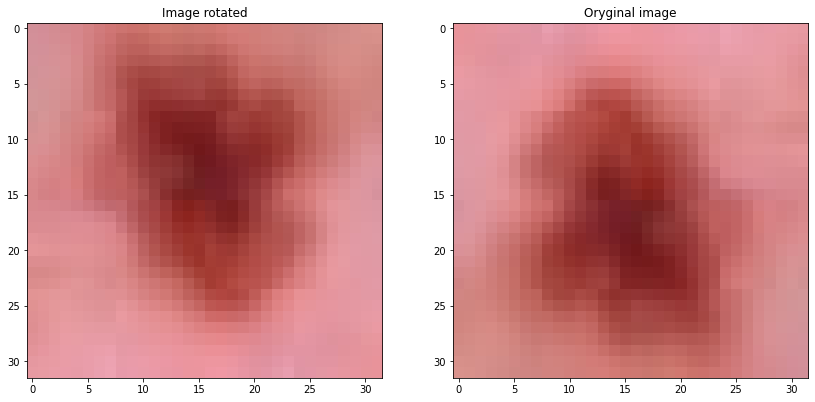

In [249]:
r = np.linspace(-2, 2, 5)    # all possible rotations by 90 degree
k = random.choice(r)
print("Rotated by {}*90 degrees".format(k))
f = Rot_90(k)
dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled', transform = f)
dark_dataset_2 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled')
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (14, 14))
ax_1.imshow(dark_dataset_1[1])
ax_1.set_title('Image rotated');
ax_2.imshow(dark_dataset_2[1])
ax_2.set_title('Oryginal image');

Rotated by 0.9035715268824775 rad
(32, 32, 3)


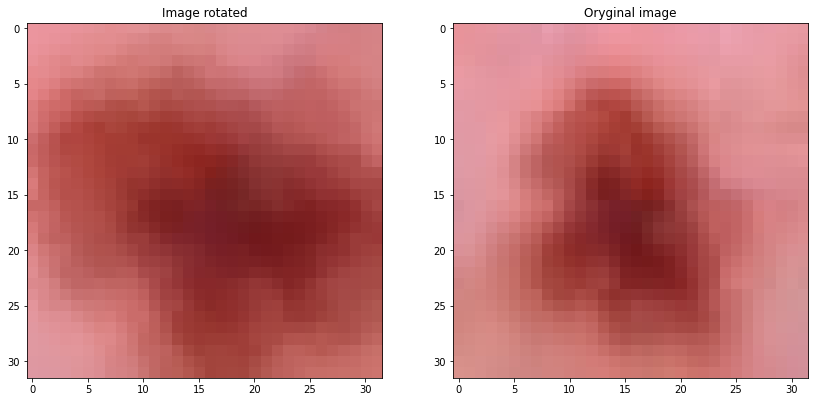

In [251]:
k = random.uniform(-np.pi/3, np.pi/3)    # rotation extracted from uniform distribution
print("Rotated by {} rad".format(k))
f = Rot(k)
dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled', transform = f)
dark_dataset_2 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled')
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (14, 14))
im = np.array(dark_dataset_1[1],np.int32)    # to be able to show in matplotlib
ax_1.imshow(im)
print(dark_dataset_1[1].shape)
ax_1.set_title('Image rotated');
ax_2.imshow(dark_dataset_2[1])
ax_2.set_title('Oryginal image');

## Scale

In [207]:
class Scale(object):
    """Rotate the object anticlockwise by 90 degree"""
    def __init__(self, scale, resize = False):    # the image does not need the resizing when cropped
        self.scale = scale
        self.resize = resize
    def __call__(self, img):
        original_size = img.shape
        img = skimage.transform.rescale(img, self.scale, mode = 'constant', multichannel = True)
        if self.resize == True:
            img = tf.image.resize_images(img, [original_size[0], original_size[1]])
        return img

Scaled by 0.9735455777499233


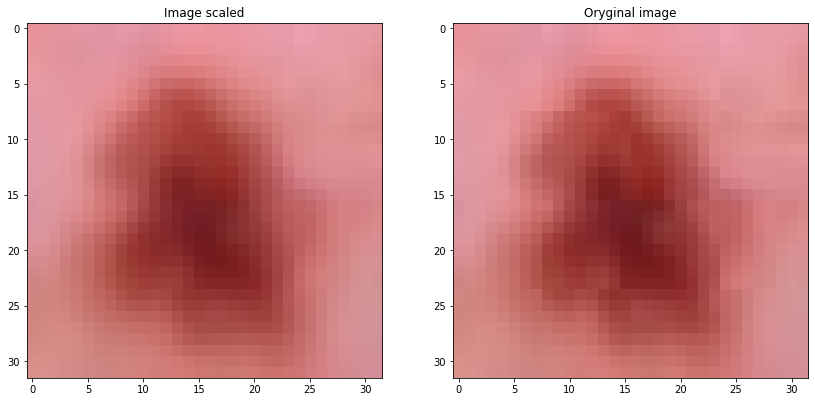

In [208]:
k = random.uniform(0.9, 1.3)    # rotation extracted from uniform distribution
print("Scaled by {}".format(k))
f = Scale(k, True)
dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled', transform = f)
dark_dataset_2 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled')
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (14, 14))
ax_1.imshow(dark_dataset_1[1])
ax_1.set_title('Image scaled');
ax_2.imshow(dark_dataset_2[1])
ax_2.set_title('Oryginal image');

## Crop

In [110]:
class Crop(object):
    """Rotate the object anticlockwise by 90 degree"""
    def __call__(self, img):
        seed = np.random.randint(1234)
        img = tf.random_crop(img, size = [32, 32, 3], seed = seed)
        return img

Above class is to be used with Scale method. After scalling up the image the script will choose randomly the cropped image with dimension [32, 32].

Scaled by 1.2835627445323918


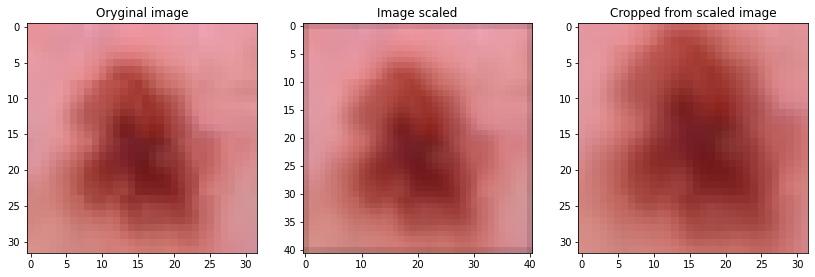

In [119]:
k = random.uniform(1.1, 1.6)    # rotation extracted from uniform distribution
print("Scaled by {}".format(k))
f = Scale(k)
f_1 = Crop()
dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled', transform = f)
dark_dataset_2 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled')
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize = (14, 14));
ax_2.imshow(dark_dataset_1[1]);
ax_2.set_title('Image scaled');
ax_1.imshow(dark_dataset_2[1]);
ax_1.set_title('Oryginal image');
ax_3.imshow(f_1(dark_dataset_1[1]));
ax_3.set_title('Cropped from scaled image');

Results of random cropping are similar to those connected to translation. Decision to skip this data augmentation method is therefor strongly justified.

## Flip

Below transformations can be used.

To use them properly class for each of them must be constructed.

In [244]:
class Flip_up(object):
    """Flip the object with respect to first dimension."""
    def __call__(self, img):
        img = tf.image.flip_up_down(img)
        return img

class Flip_side(object):
    """Flip the object with respect to first dimension."""
    def __call__(self, img):
        img = tf.image.flip_left_right(img)
        return img
class Flip_rand_up(object):
    """Flip the object with respect to first dimension."""
    def __call__(self, img):
        img = tf.image.random_flip_up_down(img)
        return img

class Flip_rand_side(object):
    """Flip the object with respect to first dimension."""
    def __call__(self, img):
        img = tf.image.random_flip_left_right(img)
        return img

First class works just fine.

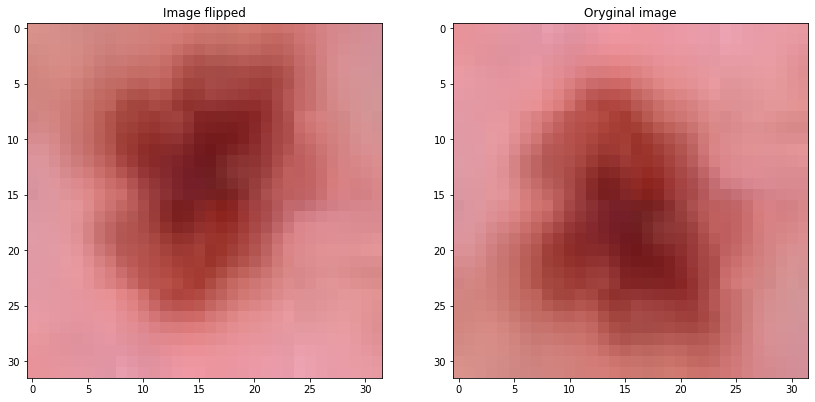

In [245]:
f = Flip_up()
dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled', transform = f)
dark_dataset_2 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled')
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (14, 14))
ax_1.imshow(dark_dataset_1[1])
ax_1.set_title('Image flipped');
ax_2.imshow(dark_dataset_2[1])
ax_2.set_title('Oryginal image');

Now below code will check whether there is sense to use all flips together.

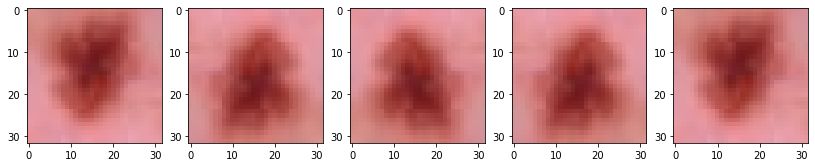

In [246]:
f_1 = Flip_up()
f_2 = Flip_side()
f_3 = Flip_rand_up()
f_4 = Flip_rand_side()
f_5 = transforms.Compose([Flip_rand_up(), Flip_rand_side()])
fig, (ax_1, ax_2, ax_3, a_4, a_5) = plt.subplots(1, 5, figsize = (14, 14))
axes = [ax_1, ax_2, ax_3, a_4, a_5]
transform = [f_1, f_2, f_3, f_4, f_5]
# Apply each of the above transforms on sample.
i = 0
for trans in transform:
    dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled',
                                           transform = trans);
    ax = axes[i];
    ax.imshow(dark_dataset_1[1]);
    i += 1
plt.show();

Random flips up and sideways are good solution to flip transformation usage.

## Gaussian noise

In [241]:
class Gaussian(object):
    """Flip the object with respect to first dimension."""
    def __call__(self, img):
        noise = tf.random_normal(shape = tf.shape(img), mean = 0.0, stddev = 1.5, dtype = tf.float32)
        img = tf.add(img, noise)
        return img

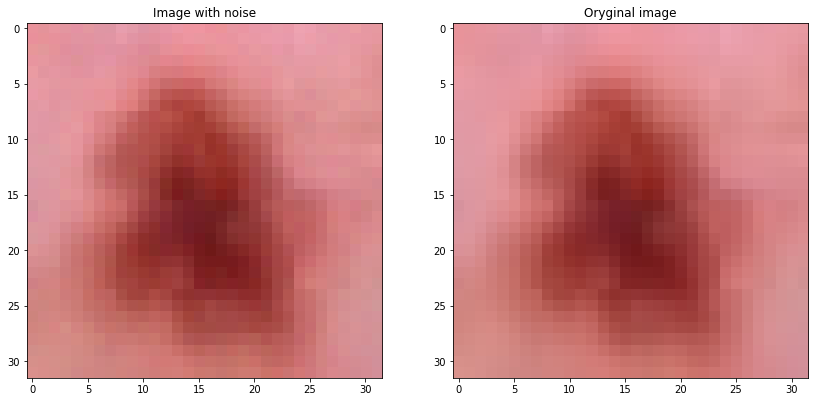

In [242]:
f = Gaussian()
dark_dataset_1 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled', transform = f)
dark_dataset_2 = MelanomaDataset_unlab(images_dir = 'MelanomaDetection/MelanomaDetection/unlabeled')
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (14, 14))
im = np.array(dark_dataset_1[1],np.int32)    # to be able to show in matplotlib
ax_1.imshow(im)
ax_1.set_title('Image with noise');
ax_2.imshow(dark_dataset_2[1])
ax_2.set_title('Oryginal image');